# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import ktrain

In [19]:
# Define epochs and batch_size
epochs = 20
bs = 32

## Preparing train and test set 

#### ImageDataGenerator is used for data augmentation. Data augmentation is a technique to artificially create new training data from existing training data. This will improve accuracy and add more training data to the model.

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [5]:
# Xception takes images of size 299, 299 as input.
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (299, 299),
                                                 batch_size = bs,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [7]:
test_set = test_datagen.flow_from_directory('data/test',
                                            target_size = (299, 299),
                                            batch_size = bs,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


## Load Xception model 

### Xception is a lightweight Keras application used in transfer learning. It takes an input image of 299 x 299

In [8]:
IMAGE_SIZE = [299, 299]
xcp = Xception(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False )

In [9]:
for layer in xcp.layers:
  layer.trainable = False

In [10]:
prediction = Flatten()(xcp.output)
prediction = Dense(1, activation = 'sigmoid')(prediction)

model = Model(inputs = xcp.input, outputs = prediction)

In [11]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Using Ktrain library to find the optimal learning rate 

In [12]:
learner = ktrain.get_learner(model,
    train_data = training_set,
    val_data = test_set,
    batch_size = 32,
    eval_batch_size = 32,
    workers = 4)

In [13]:
learner.lr_find(max_epochs = 5, class_weight = {0:3, 1:1})

simulating training for different learning rates... this may take a few moments...


C:\Users\Madridista\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
163/163 [==============================] - 695s 4s/step - loss: 0.9368 - accuracy: 0.6733
Epoch 2/5
163/163 [==============================] - 689s 4s/step - loss: 0.4011 - accuracy: 0.8970
Epoch 3/5
163/163 [==============================] - 829s 5s/step - loss: 1.0695 - accuracy: 0.9158
Epoch 4/5
163/163 [==============================] - 31s 132ms/step - loss: 6.6728 - accuracy: 0.8938


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


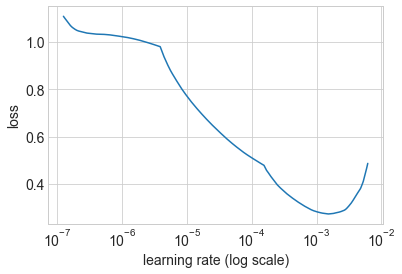

In [14]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})
learner.lr_plot()

In [21]:
# Taking 8e-2 as learning rate after checking lr_plot
optimizer = Adam(learning_rate = 8e-2)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [22]:
# This callback will save the model which has the best validation accuracy in epoch, as 'Xception.h5'
checkpoint = ModelCheckpoint('Xception.h5', monitor = 'val_accuracy', save_best_only = True)

### Training the model 

In [28]:
# Using class_weight since its kind of an imbalanced dataset. (NORMAL - 1341, PNEUMONIA - 3875)
r = model.fit(x = training_set,
        batch_size = bs,
        epochs = epochs,
        callbacks = checkpoint,
        steps_per_epoch = 4 * (len(training_set) // bs),
        validation_data = test_set,
        class_weight = {0:3, 1:1},
        workers = 4)

Epoch 1/20
20/20 [==============================] - 211s 11s/step - loss: 86.2357 - accuracy: 0.9172 - val_loss: 112.9588 - val_accuracy: 0.8862
Epoch 2/20
20/20 [==============================] - 189s 9s/step - loss: 59.7571 - accuracy: 0.9594 - val_loss: 148.9368 - val_accuracy: 0.8638
Epoch 3/20
20/20 [==============================] - 170s 9s/step - loss: 51.7476 - accuracy: 0.9531 - val_loss: 87.7897 - val_accuracy: 0.9103
Epoch 4/20
20/20 [==============================] - 171s 9s/step - loss: 115.7036 - accuracy: 0.9328 - val_loss: 171.2505 - val_accuracy: 0.8686
Epoch 5/20
20/20 [==============================] - 169s 9s/step - loss: 59.5409 - accuracy: 0.9547 - val_loss: 117.4588 - val_accuracy: 0.9006
Epoch 6/20
20/20 [==============================] - 170s 9s/step - loss: 60.8402 - accuracy: 0.9563 - val_loss: 81.8769 - val_accuracy: 0.9167
Epoch 7/20
20/20 [==============================] - 169s 9s/step - loss: 39.0126 - accuracy: 0.9641 - val_loss: 133.6173 - val_accuracy:

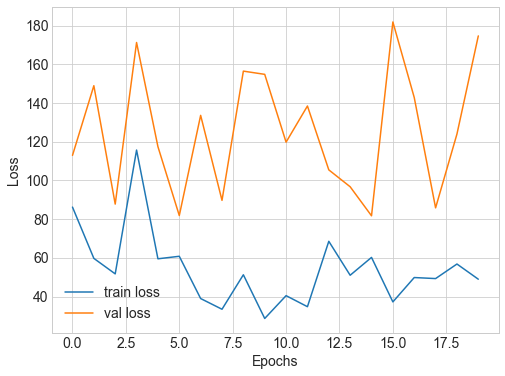

In [29]:
# plotting loss and val_loss
plt.figure(figsize = (8, 6))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

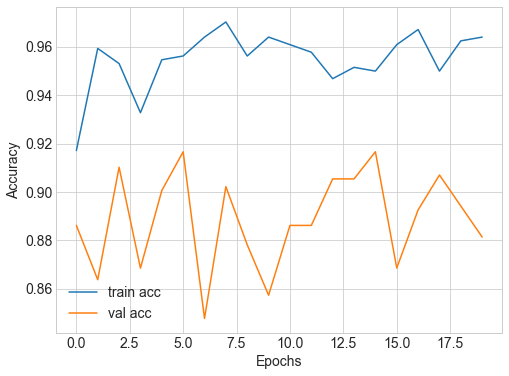

In [30]:
# plotting train and test accuracy
plt.figure(figsize = (8, 6))
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing with unseen test data 

In [48]:
test_image = load_img('data/test/NORMAL/NORMAL2-IM-0319-0001.jpeg', target_size = (299, 299))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = preprocess_input(test_image)
result = model.predict(test_image)
result[0][0]

0.0

In [36]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}